In [3]:
# pinn_model.py

import torch
import torch.nn as nn
import numpy as np
import pickle

# --- 1. Define the PINN Architecture ---
class RacingPINN(nn.Module):
    def __init__(self, num_hidden_layers=8, hidden_size=256):
        """
        A Physics-Informed Neural Network for Racing Line Optimization.

        Args:
            num_hidden_layers (int): Number of hidden layers in the network.
            hidden_size (int): Number of neurons in each hidden layer.
        """
        super().__init__()

        # Input layer (s) -> hidden
        layers = [nn.Linear(1, hidden_size), nn.Tanh()]

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.Tanh()])

        # Output layer hidden -> (x, y, speed)
        layers.append(nn.Linear(hidden_size, 3))

        self.net = nn.Sequential(*layers)

    def forward(self, s):
        """
        Performs a forward pass through the network.

        Args:
            s (torch.Tensor): A tensor of shape [N, 1] representing the
                              normalized distance along the track.
                              Must have requires_grad=True for derivative calculations.

        Returns:
            torch.Tensor: A tensor of shape [N, 3] with the predicted
                          [x, y, speed] for each point s.
        """
        return self.net(s)

In [4]:
# Add this code to pinn_model.py

# --- 2. Load and Prepare Data ---
def load_training_data(path_to_data='silverstone_2023_training.pkl'):
    """Loads the pre-processed training data from the pickle file."""
    print("Loading training data...")
    with open(path_to_data, 'rb') as f:
        data = pickle.load(f)
    
    # We will use the very first lap (the fastest one) as our ground truth
    # Shape: (1000, 2) for position, (1000,) for speed
    x_true = data['positions'][0, :, 0]
    y_true = data['positions'][0, :, 1]
    speed_true = data['speeds'][0, :]

    # Create the 's' input tensor (normalized distance)
    num_points = len(x_true)
    s_tensor = torch.linspace(0, 1, num_points, dtype=torch.float32).view(-1, 1)
    
    # Create the ground truth output tensor
    # Shape: (1000, 3)
    ground_truth = torch.tensor(np.vstack((x_true, y_true, speed_true)).T, dtype=torch.float32)
    
    print("✓ Data loaded and converted to tensors.")
    return s_tensor, ground_truth

In [1]:
# Add this cell to your notebook and run it once.

from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
import numpy as np

@dataclass
class TrackGeometry:
    """Container for track geometry data"""
    name: str
    year: int
    track_bounds: Dict[str, np.ndarray]
    racing_lines: Dict[str, np.ndarray]
    elevation: Optional[np.ndarray] = None
    sectors: Optional[Dict] = None
    metadata: Optional[Dict] = None

# It's good practice to also include the TelemetryData class,
# as you'll need it when you load the other pickle file later.
@dataclass
class TelemetryData:
    """Container for processed telemetry data"""
    driver: str
    lap_number: int
    lap_time: float
    positions: np.ndarray
    speeds: np.ndarray
    throttle: np.ndarray
    brake: np.ndarray
    gear: np.ndarray
    rpm: np.ndarray
    drs: np.ndarray
    steering: Optional[np.ndarray] = None
    g_forces: Optional[Dict[str, np.ndarray]] = None

print("Dataclasses defined successfully.")

Dataclasses defined successfully.


In [3]:
# Cell 1: Imports, Constants, and Data Loading

import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path # This is crucial for the boundary check

# --- Physical Constants (from your project description) ---
# All units are in SI (meters, kg, seconds, etc.)
F1_MASS = 798.0  # kg
F1_POWER = 746000.0  # Watts (~1000 HP)
F1_DRAG_COEFF = 1.0 # Drag Coefficient
F1_DOWNFORCE_COEFF = 3.5 # Downforce Coefficient (negative is standard for lift)
F1_FRICTION_COEFF = 2.5 # Tire friction coefficient for racing slicks
AIR_DENSITY = 1.225 # kg/m^3
GRAVITY = 9.81 # m/s^2
FRONTAL_AREA = 1.5 # m^2, an assumption, but reasonable for an F1 car

# --- Load Geometry for Boundaries ---
with open('data_cache/silverstone_2023_geometry.pkl', 'rb') as f:
    geometry = pickle.load(f)
    
inner_boundary = torch.tensor(geometry.track_bounds['inner'], dtype=torch.float32)
outer_boundary = torch.tensor(geometry.track_bounds['outer'], dtype=torch.float32)

# Create matplotlib Path objects for efficient checking
outer_path = Path(outer_boundary.numpy())
inner_path = Path(inner_boundary.numpy())

print("Setup complete. Physical constants and track boundaries are loaded.")

Setup complete. Physical constants and track boundaries are loaded.


In [14]:
# REVISED Cell 2: The PINN Trainer Class

class RacingPINNTrainer:
    def __init__(self, model, s_tensor, ground_truth, scaler):
        self.model = model
        self.s = s_tensor.clone().detach().requires_grad_(True)
        self.gt = ground_truth
        self.scaler = scaler # Store the scaler
        
        self.s_no_grad = s_tensor
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        self.history = {'data_loss': [], 'physics_loss': [], 'boundary_loss': [], 'total_loss': []}

    # ... (keep your compute_data_loss, compute_boundary_loss, and compute_physics_loss methods exactly as they are) ...
    def compute_data_loss(self, predicted):
        return nn.functional.mse_loss(predicted, self.gt)

    def compute_boundary_loss(self, predicted_xy):
        # Un-normalize the data before checking boundaries
        predicted_xy_unnormalized = self.scaler.inverse_transform(predicted_xy.detach().numpy())

        outside_outer = ~outer_path.contains_points(predicted_xy_unnormalized)
        inside_inner = inner_path.contains_points(predicted_xy_unnormalized)
        
        violations = torch.tensor(outside_outer | inside_inner, dtype=torch.float32)
        
        # We'll use a smaller multiplier now that the data loss is smaller
        loss = torch.mean(violations) * 100 
        return loss

    def compute_physics_loss(self, predicted):
        # Un-normalize before physics calculations
        predicted_unnormalized = self.scaler.inverse_transform(predicted.detach().clone())
        x, y, v = predicted_unnormalized[:, 0], predicted_unnormalized[:, 1], predicted_unnormalized[:, 2]
        
        # We need to re-enable gradients for the un-normalized outputs
        x.requires_grad_(True)
        y.requires_grad_(True)

        # First derivatives
        dxd_s = torch.autograd.grad(x, self.s, torch.ones_like(x), create_graph=True, allow_unused=True)[0]
        dyd_s = torch.autograd.grad(y, self.s, torch.ones_like(y), create_graph=True, allow_unused=True)[0]
        
        if dxd_s is None or dyd_s is None: return torch.tensor(0.0)

        # Second derivatives
        d2xd_s2 = torch.autograd.grad(dxd_s, self.s, torch.ones_like(dxd_s), create_graph=True, allow_unused=True)[0]
        d2yd_s2 = torch.autograd.grad(dyd_s, self.s, torch.ones_like(dyd_s), create_graph=True, allow_unused=True)[0]
        
        if d2xd_s2 is None or d2yd_s2 is None: return torch.tensor(0.0)

        # Curvature
        numerator = torch.abs(dxd_s * d2yd_s2 - dyd_s * d2xd_s2)
        denominator = (dxd_s**2 + dyd_s**2)**(3/2)
        kappa = numerator / (denominator + 1e-6)

        # Tire Grip
        speed_ms = v
        downforce = 0.5 * F1_DOWNFORCE_COEFF * AIR_DENSITY * (speed_ms**2) * FRONTAL_AREA
        max_grip_force = F1_FRICTION_COEFF * (F1_MASS * GRAVITY + downforce)
        required_grip_force = F1_MASS * (speed_ms**2) * kappa
        grip_loss = torch.mean(torch.relu(required_grip_force - max_grip_force))
        
        return grip_loss

    def train(self, epochs, pretrain_epochs=500, physics_weight=1.0, boundary_weight=1.0):
        # ... (training loop is the same, but the plot_progress call will now work) ...
        print("Starting training...")
        
        print("\n--- STAGE 1: Pre-training (learning the basic track shape) ---")
        for epoch in range(pretrain_epochs):
            self.optimizer.zero_grad()
            predicted_path = self.model(self.s_no_grad)
            loss = self.compute_data_loss(predicted_path)
            loss.backward()
            self.optimizer.step()
            if epoch % 100 == 0:
                print(f"Pre-train Epoch {epoch}/{pretrain_epochs}, Data Loss: {loss.item():.4f}")

        print("\n--- STAGE 2: Physics-Informed Fine-tuning ---")
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            predicted_path = self.model(self.s)
            
            data_loss = self.compute_data_loss(predicted_path)
            # Pass the normalized xy values to the boundary loss
            boundary_loss = self.compute_boundary_loss(predicted_path[:, :2])
            # Pass the full normalized prediction to physics loss
            physics_loss = self.compute_physics_loss(predicted_path)
            
            total_loss = data_loss + physics_weight * physics_loss + boundary_weight * boundary_loss
            total_loss.backward()
            self.optimizer.step()
            
            self.history['data_loss'].append(data_loss.item())
            self.history['physics_loss'].append(physics_loss.item())
            self.history['boundary_loss'].append(boundary_loss.item())
            self.history['total_loss'].append(total_loss.item())
            
            if epoch % 200 == 0:
                print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item():.4f} | "
                      f"Data: {data_loss.item():.4f}, Physics: {physics_loss.item():.4f}, Boundary: {boundary_loss.item():.4f}")
                self.plot_progress()

    def plot_progress(self):
        self.model.eval()
        with torch.no_grad():
            # Get the model's prediction (which is normalized)
            predicted_normalized = self.model(self.s_no_grad)
        self.model.train()

        # Inverse transform both prediction and ground truth to original scale for plotting
        predicted_unnormalized = self.scaler.inverse_transform(predicted_normalized.numpy())
        gt_unnormalized = self.scaler.inverse_transform(self.gt.numpy())

        plt.figure(figsize=(16, 6))
        
        # Plot 1: Track Layout
        plt.subplot(1, 2, 1)
        plt.plot(outer_boundary[:, 0], outer_boundary[:, 1], 'k-', label='Outer Boundary')
        plt.plot(inner_boundary[:, 0], inner_boundary[:, 1], 'k-', label='Inner Boundary')
        plt.plot(gt_unnormalized[:, 0], gt_unnormalized[:, 1], 'b--', alpha=0.7, label='Real Lap (VER)')
        plt.plot(predicted_unnormalized[:, 0], predicted_unnormalized[:, 1], 'r-', linewidth=2, label='PINN Prediction')
        plt.title('Track Layout and Racing Lines')
        plt.xlabel('X (m)'); plt.ylabel('Y (m)')
        plt.legend(); plt.axis('equal')

        # Plot 2: Loss History
        plt.subplot(1, 2, 2)
        for key, value in self.history.items():
             if key != 'total_loss':
                 plt.plot(value, label=key)
        plt.title('Loss History'); plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.yscale('log'); plt.legend(); plt.grid(True)
        
        plt.tight_layout()
        plt.show()

✓ Data loaded and NORMALIZED.
Starting training...

--- STAGE 1: Pre-training (learning the basic track shape) ---
Pre-train Epoch 0/1000, Data Loss: 0.4693
Pre-train Epoch 100/1000, Data Loss: 0.0681
Pre-train Epoch 200/1000, Data Loss: 0.0385
Pre-train Epoch 300/1000, Data Loss: 0.0270
Pre-train Epoch 400/1000, Data Loss: 0.0240
Pre-train Epoch 500/1000, Data Loss: 0.0174
Pre-train Epoch 600/1000, Data Loss: 0.0102
Pre-train Epoch 700/1000, Data Loss: 0.0060
Pre-train Epoch 800/1000, Data Loss: 0.0052
Pre-train Epoch 900/1000, Data Loss: 0.0045

--- STAGE 2: Physics-Informed Fine-tuning ---
Epoch 0/4000, Total Loss: 9.8740 | Data: 0.0040, Physics: 0.0000, Boundary: 98.7000


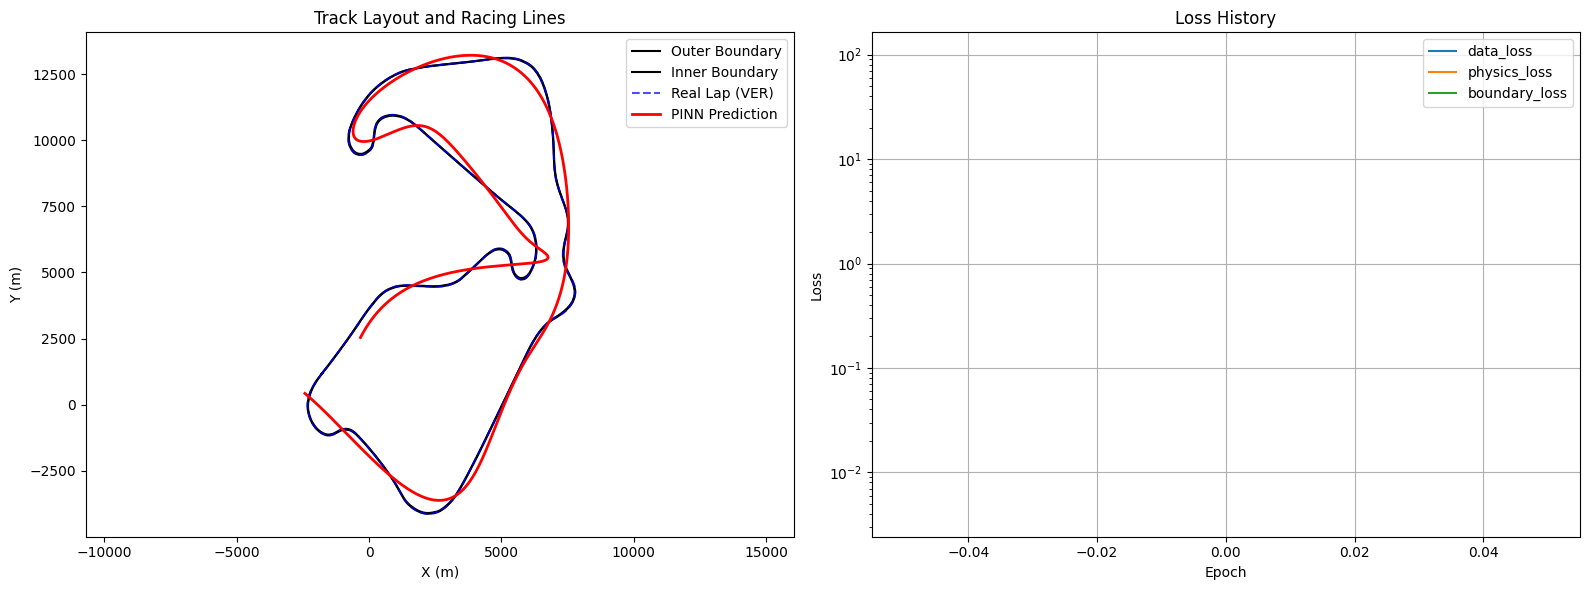

Epoch 200/4000, Total Loss: 9.8735 | Data: 0.0035, Physics: 0.0000, Boundary: 98.7000


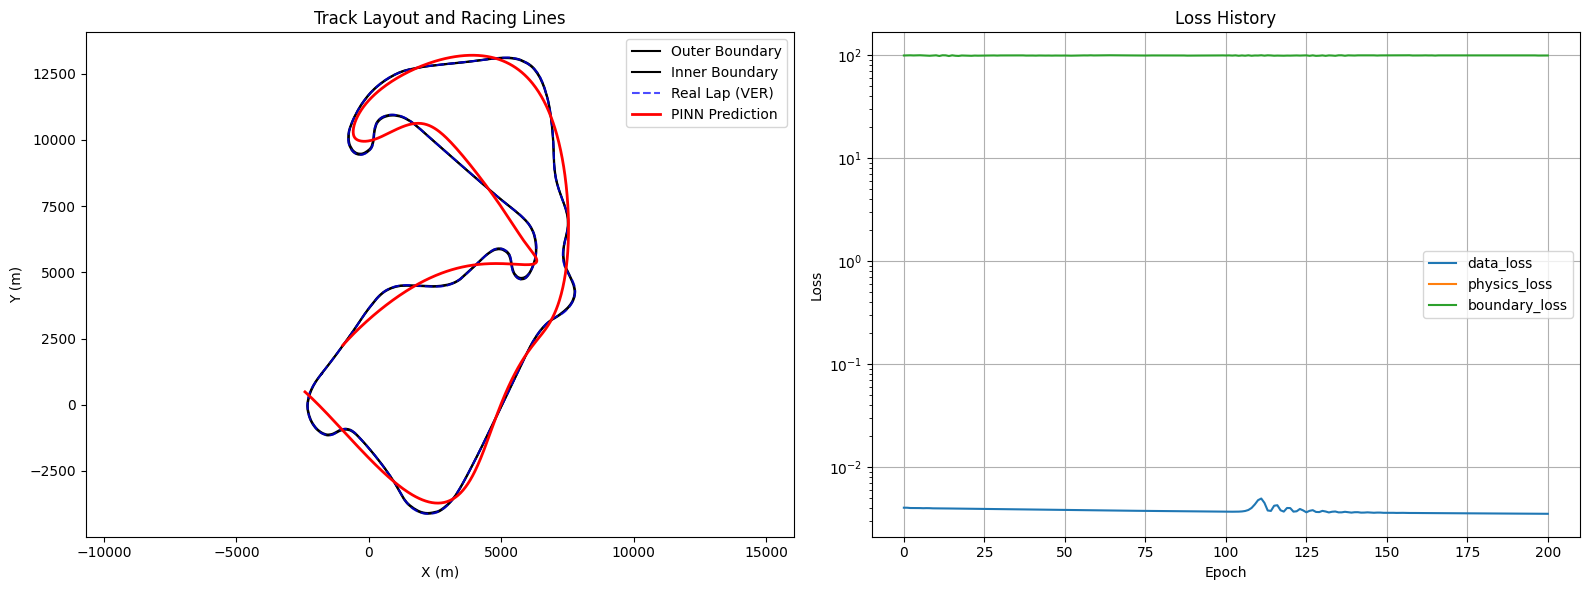

Epoch 400/4000, Total Loss: 9.9033 | Data: 0.0033, Physics: 0.0000, Boundary: 99.0000


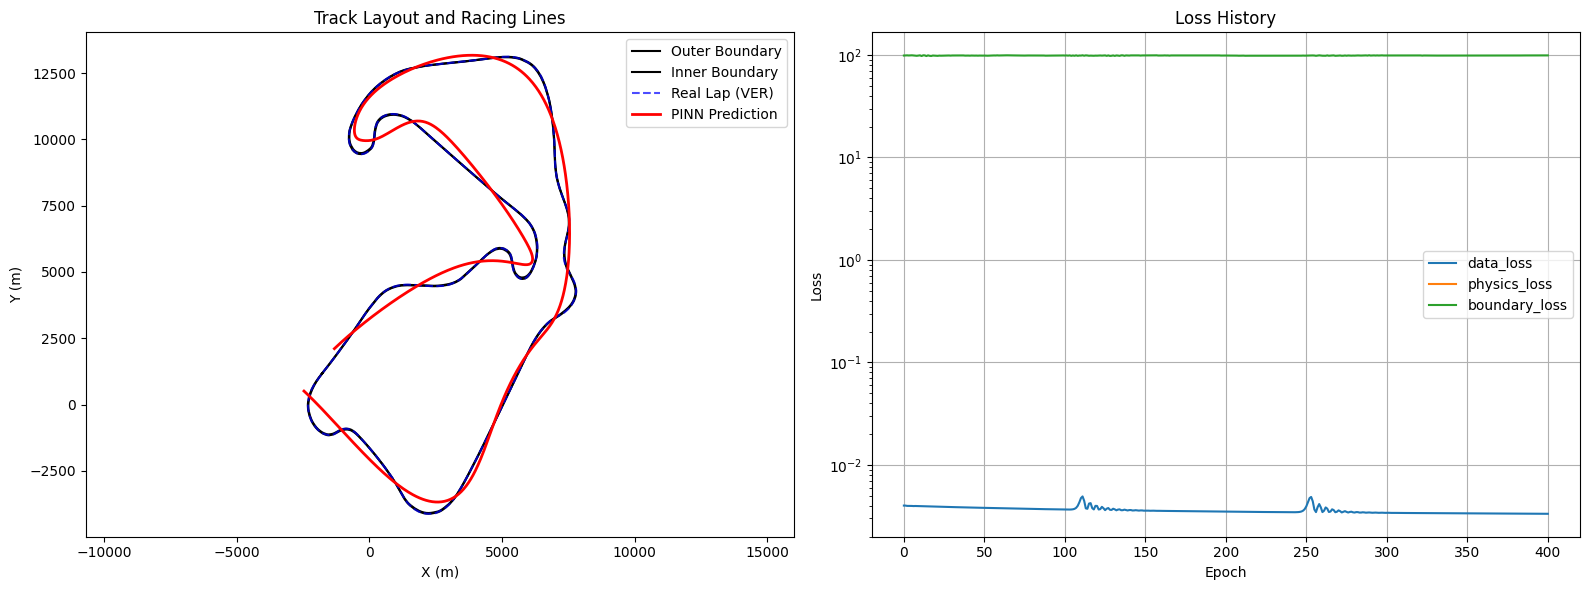

Epoch 600/4000, Total Loss: 9.8533 | Data: 0.0033, Physics: 0.0000, Boundary: 98.5000


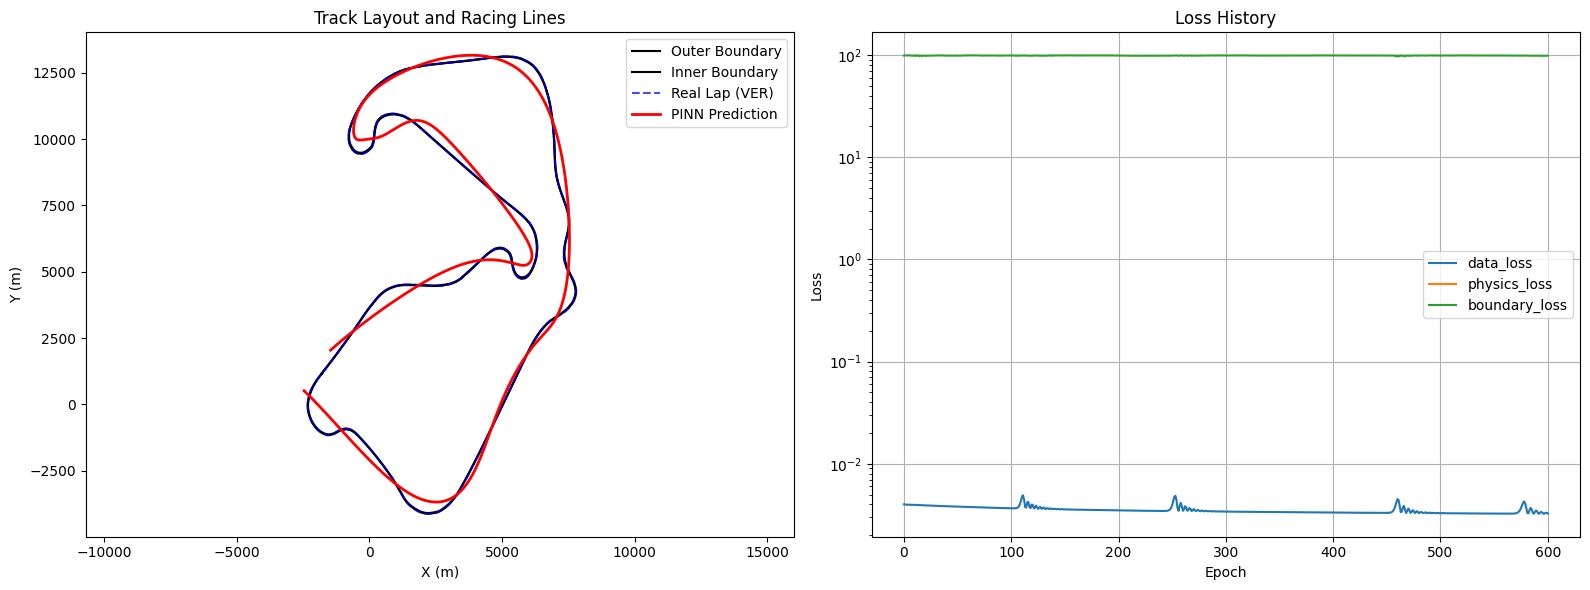

Epoch 800/4000, Total Loss: 9.7431 | Data: 0.0031, Physics: 0.0000, Boundary: 97.4000


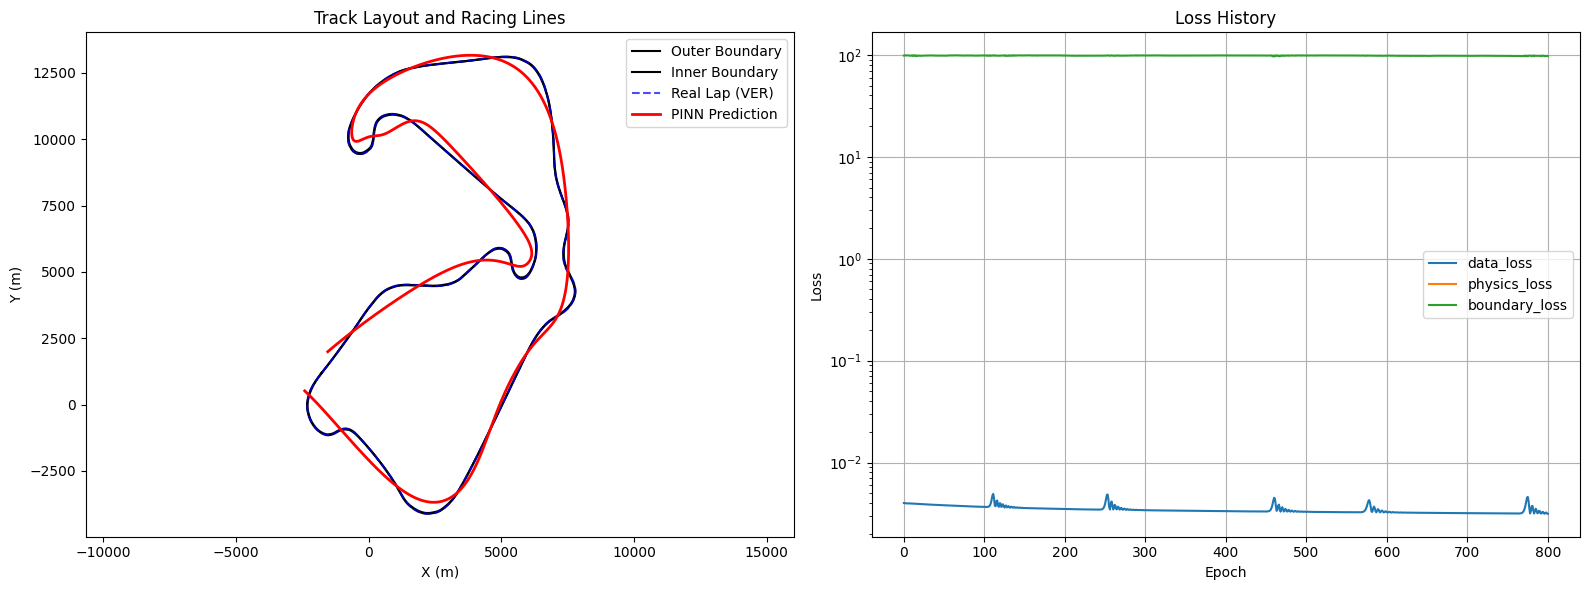

Epoch 1000/4000, Total Loss: 9.8030 | Data: 0.0030, Physics: 0.0000, Boundary: 98.0000


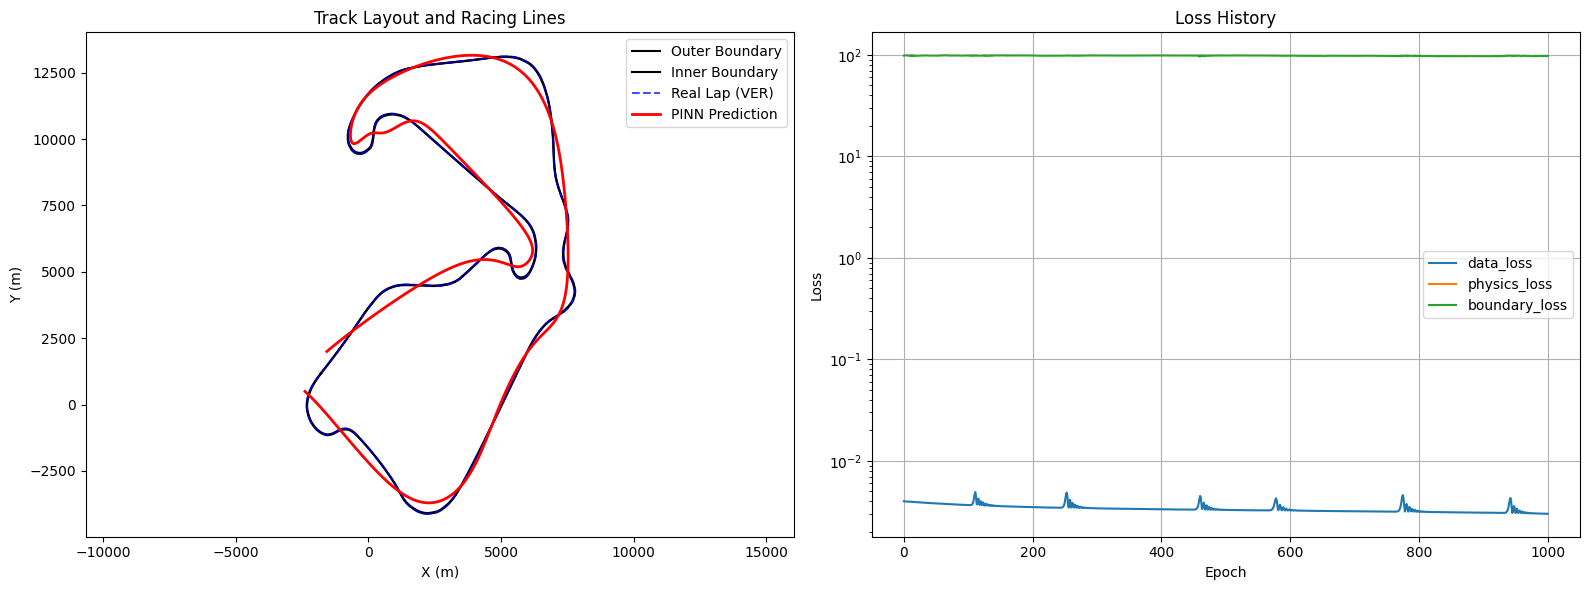

Epoch 1200/4000, Total Loss: 9.7926 | Data: 0.0026, Physics: 0.0000, Boundary: 97.9000


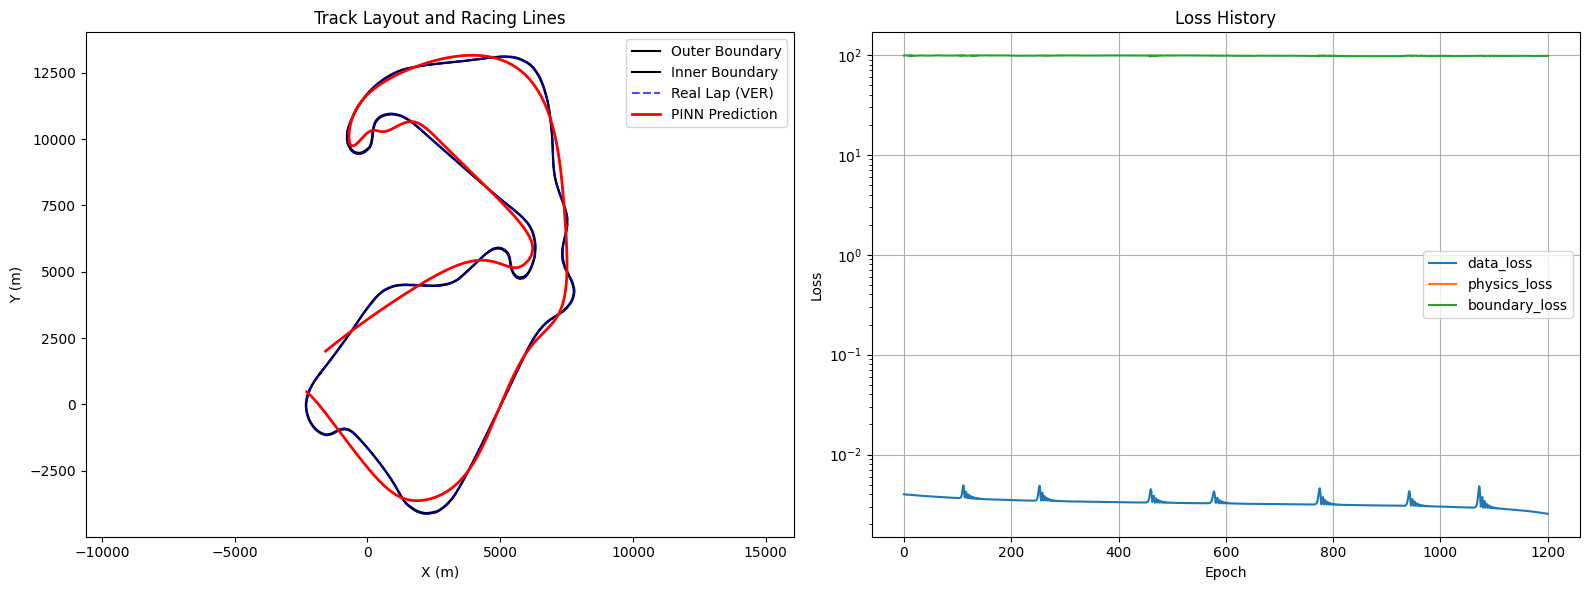

Epoch 1400/4000, Total Loss: 9.8312 | Data: 0.0012, Physics: 0.0000, Boundary: 98.3000


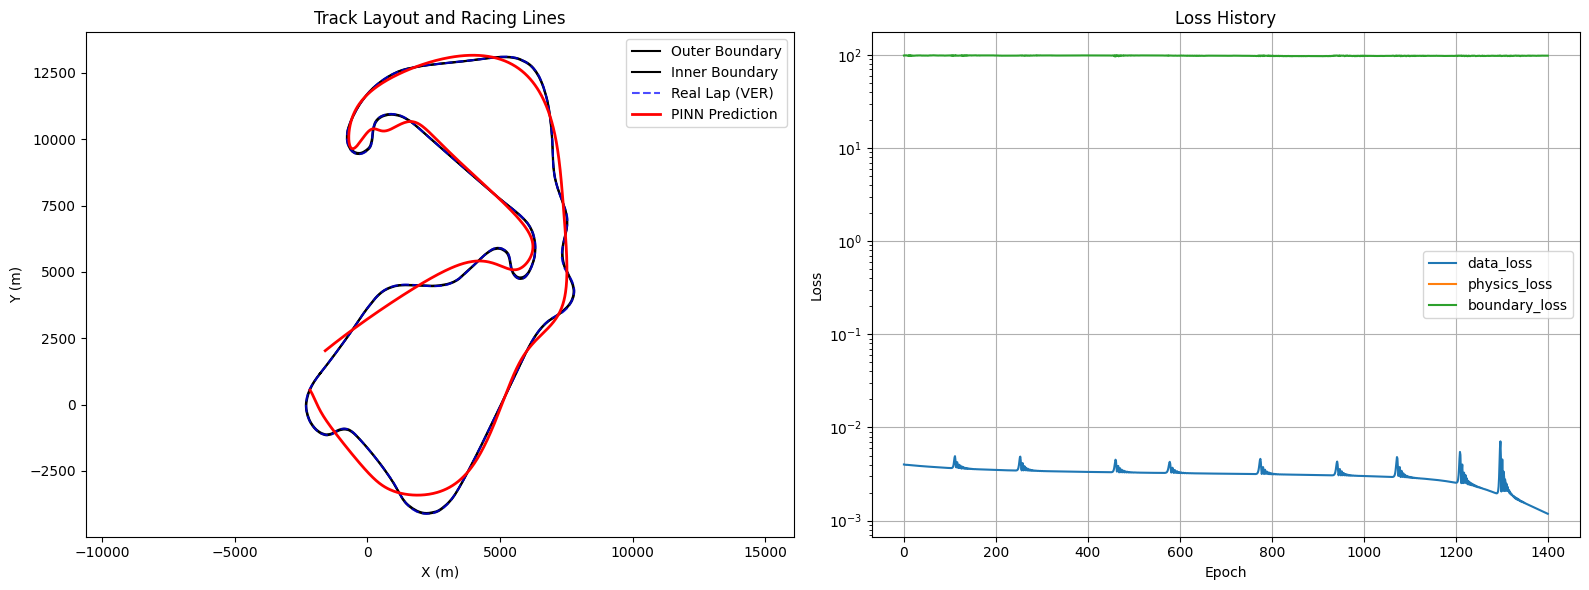

Epoch 1600/4000, Total Loss: 9.7807 | Data: 0.0007, Physics: 0.0000, Boundary: 97.8000


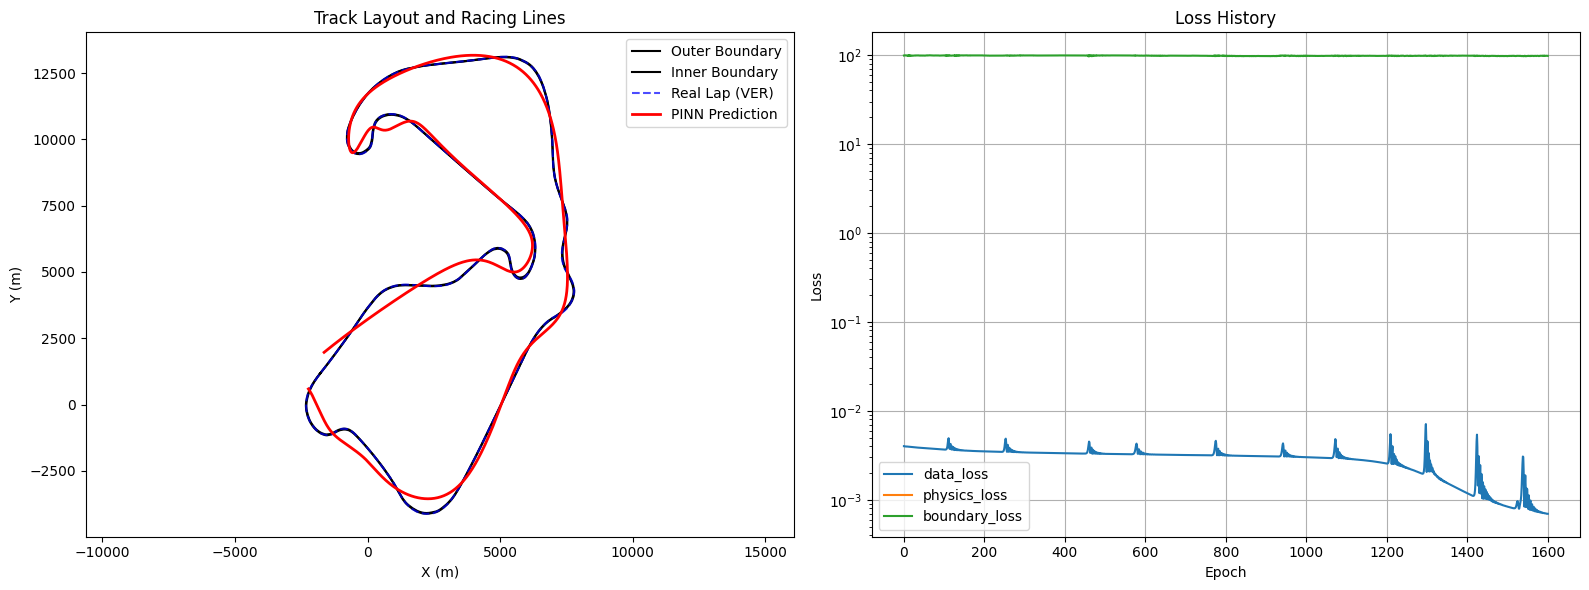

Epoch 1800/4000, Total Loss: 9.7607 | Data: 0.0007, Physics: 0.0000, Boundary: 97.6000


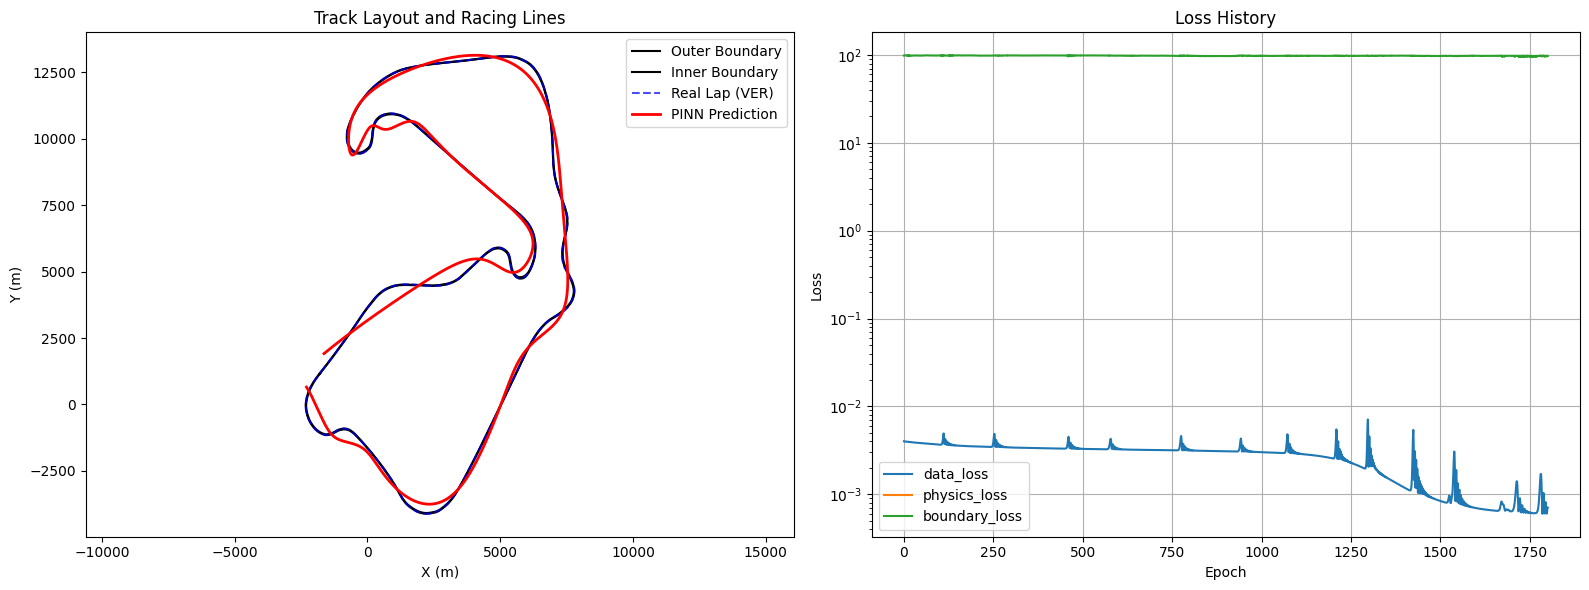

Epoch 2000/4000, Total Loss: 9.6705 | Data: 0.0005, Physics: 0.0000, Boundary: 96.7000


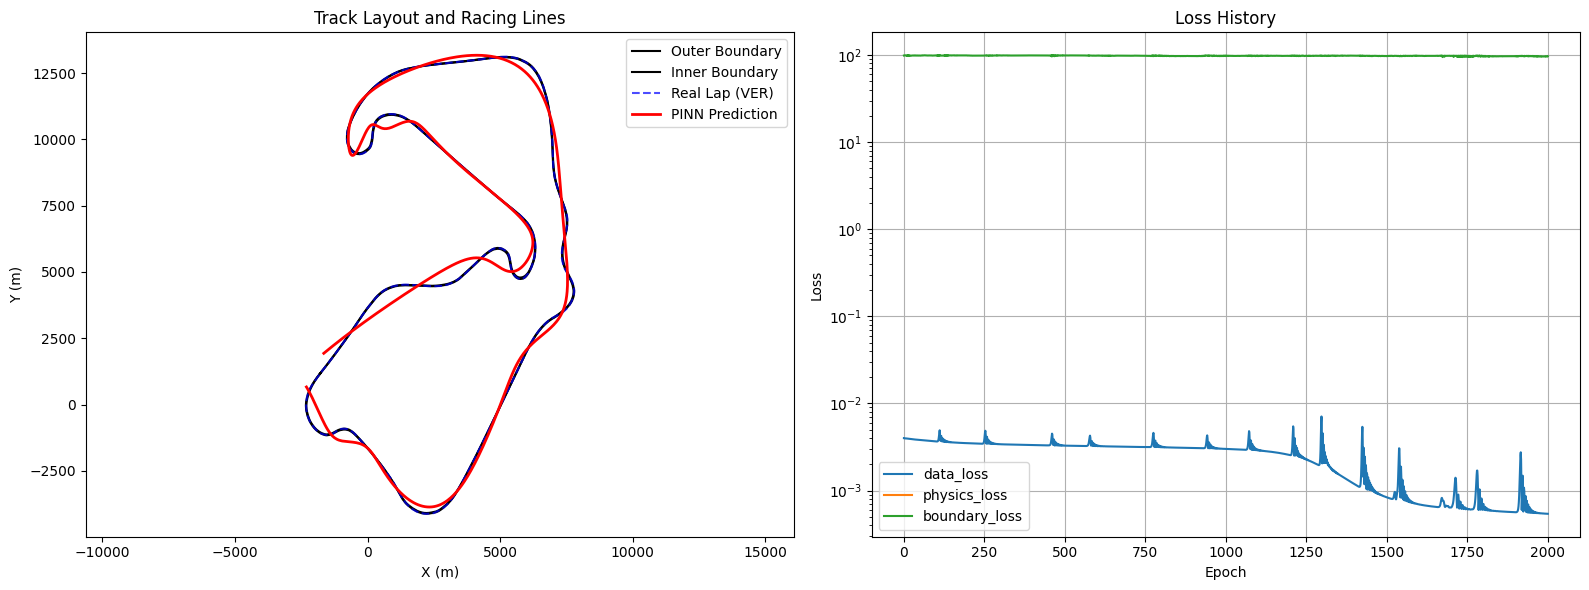

Epoch 2200/4000, Total Loss: 9.7605 | Data: 0.0005, Physics: 0.0000, Boundary: 97.6000


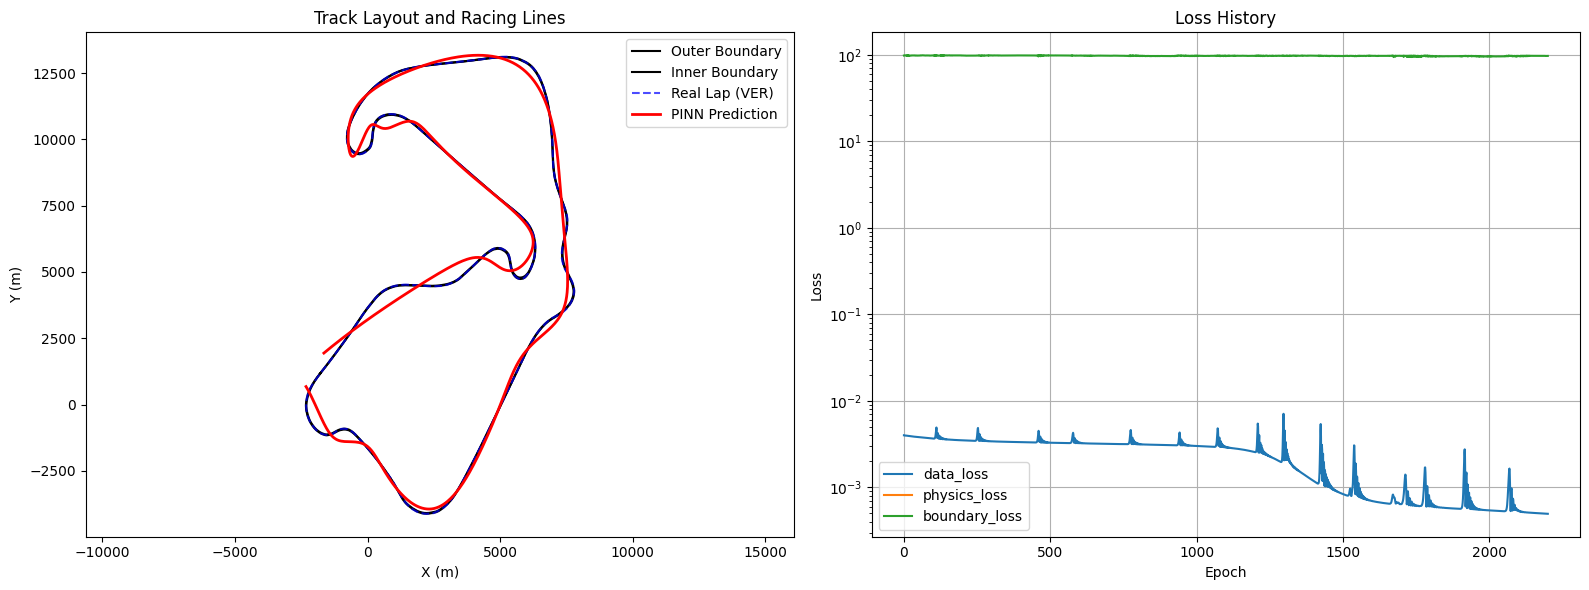

Epoch 2400/4000, Total Loss: 9.7405 | Data: 0.0005, Physics: 0.0000, Boundary: 97.4000


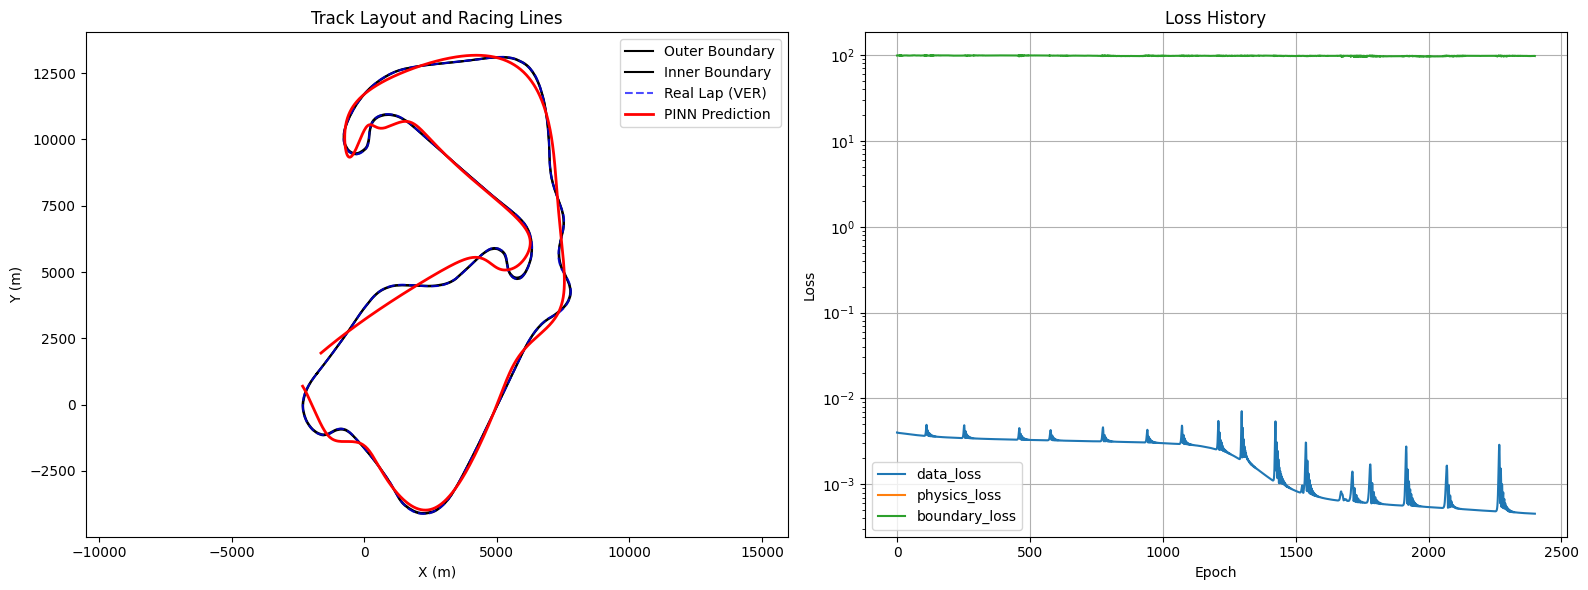

Epoch 2600/4000, Total Loss: 9.7204 | Data: 0.0004, Physics: 0.0000, Boundary: 97.2000


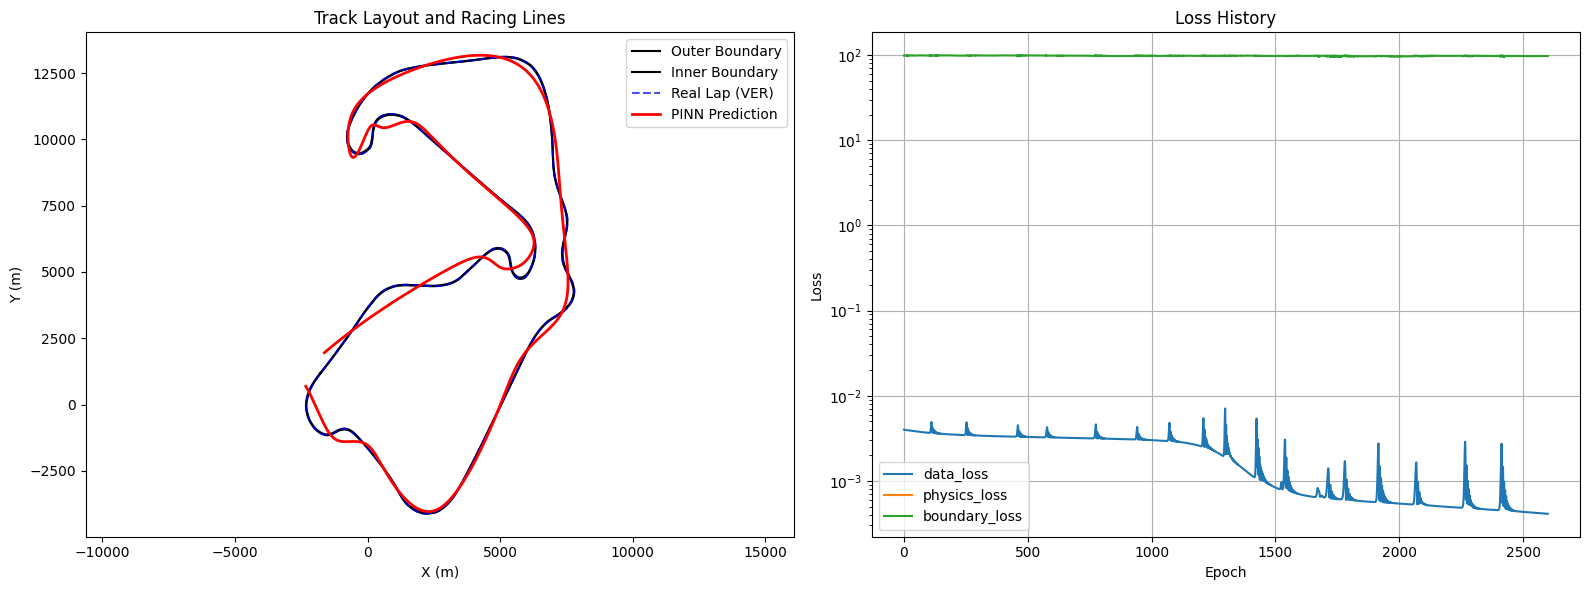

Epoch 2800/4000, Total Loss: 9.7004 | Data: 0.0004, Physics: 0.0000, Boundary: 97.0000


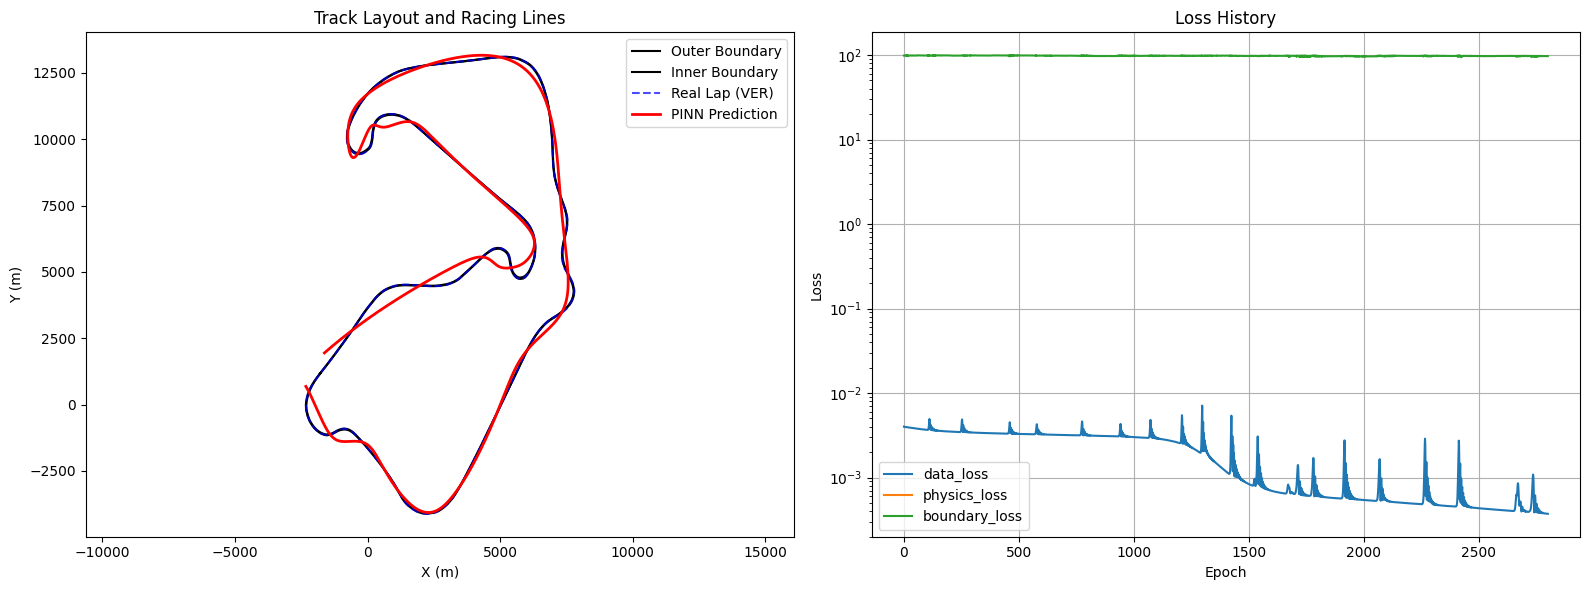

Epoch 3000/4000, Total Loss: 9.5604 | Data: 0.0004, Physics: 0.0000, Boundary: 95.6000


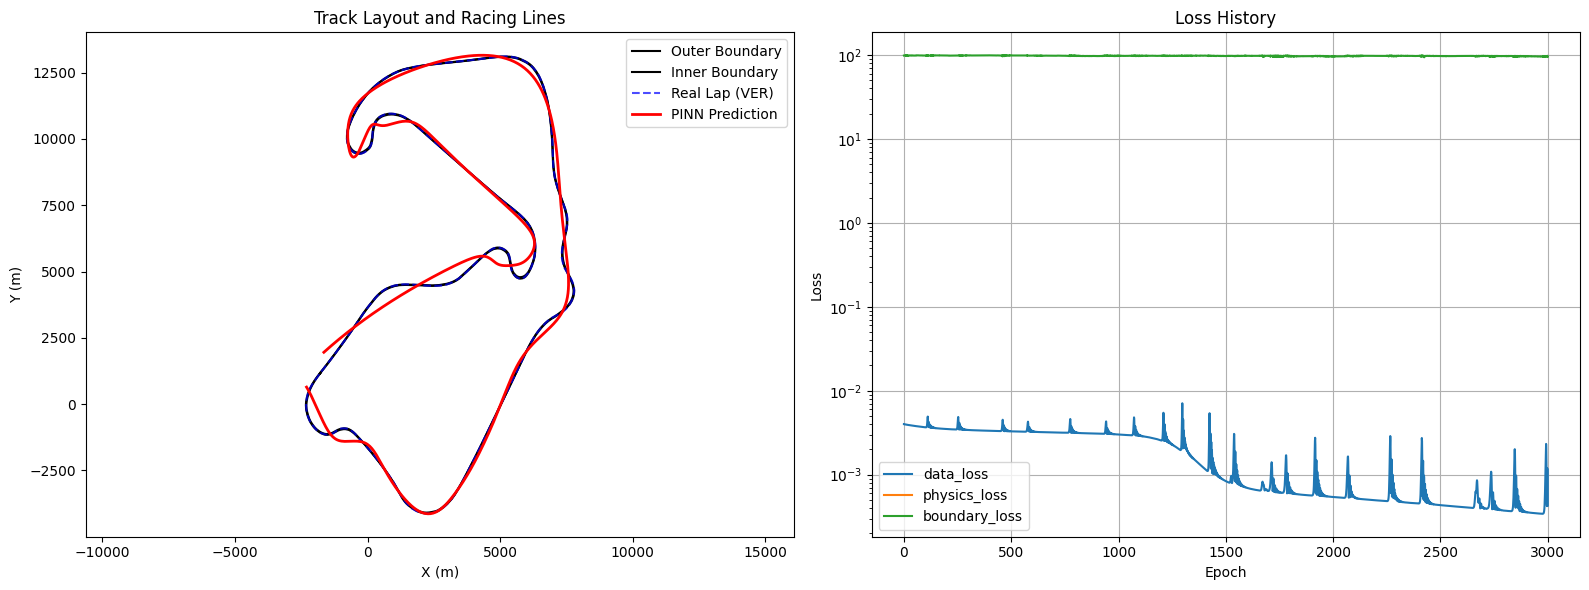

Epoch 3200/4000, Total Loss: 9.5609 | Data: 0.0009, Physics: 0.0000, Boundary: 95.6000


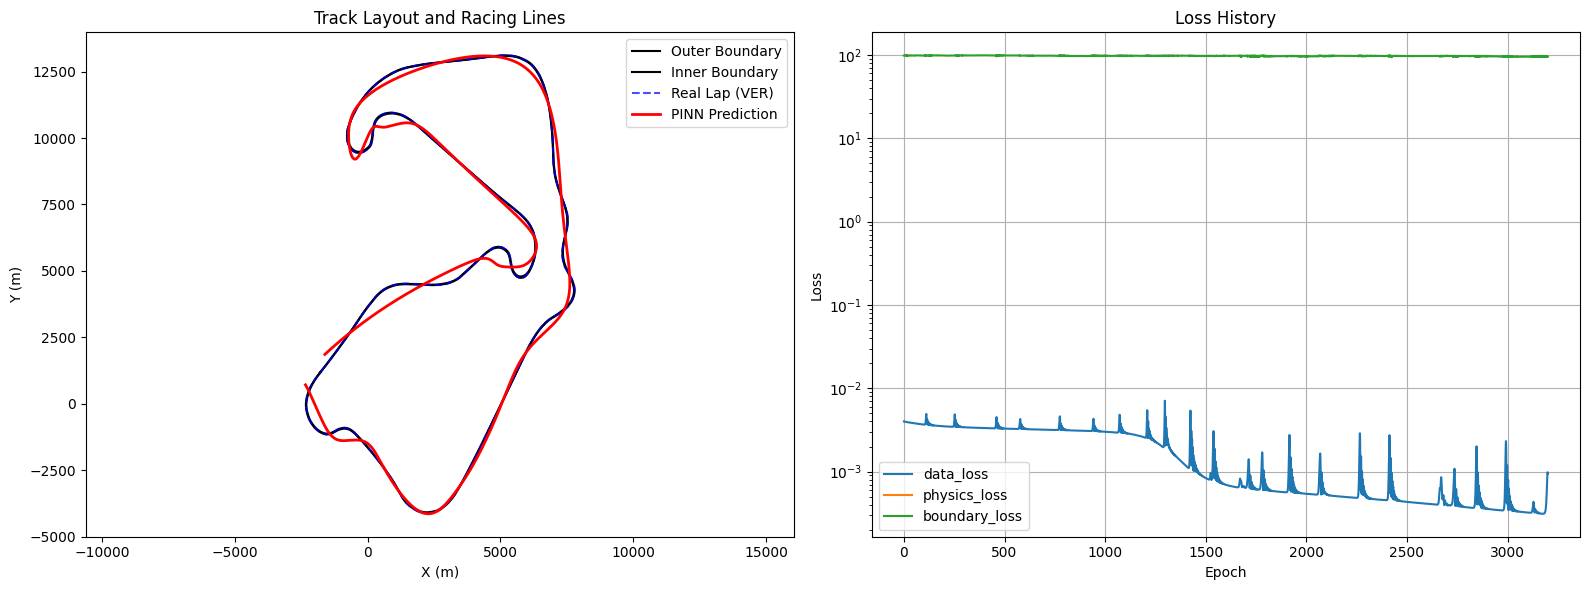

Epoch 3400/4000, Total Loss: 9.6503 | Data: 0.0003, Physics: 0.0000, Boundary: 96.5000


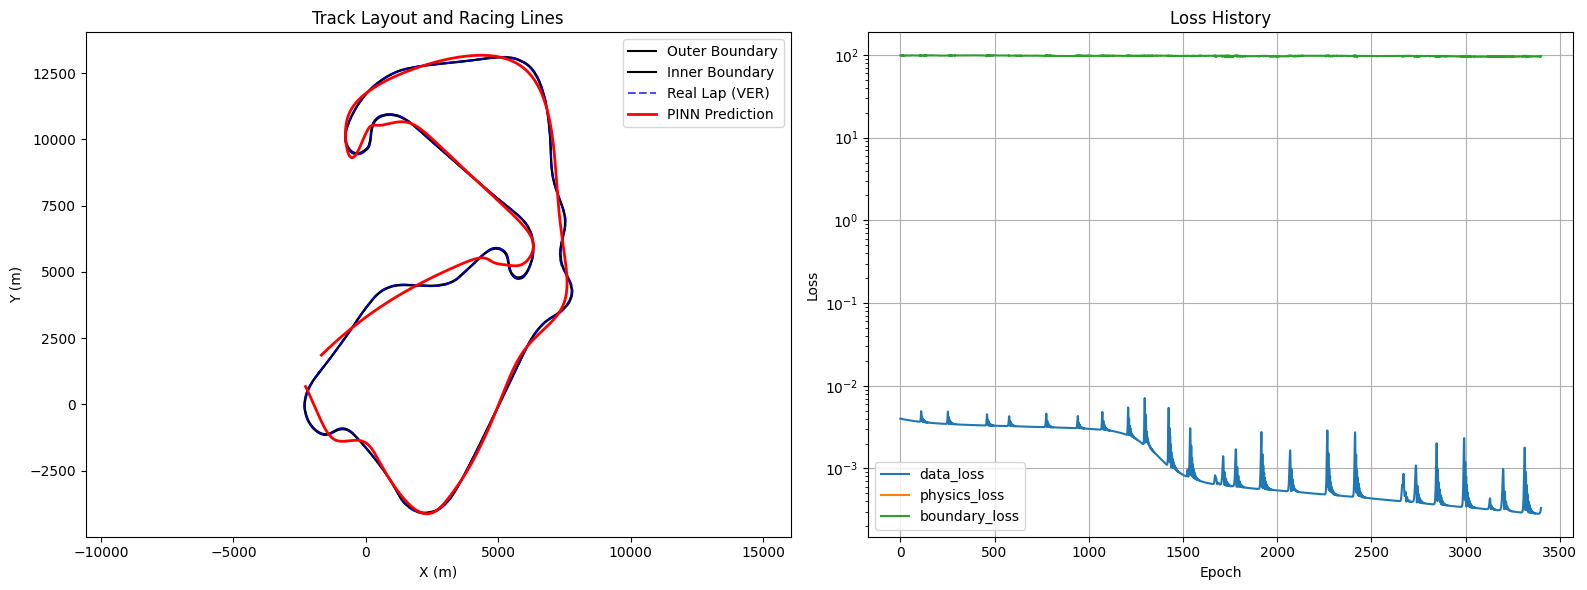

Epoch 3600/4000, Total Loss: 9.6103 | Data: 0.0003, Physics: 0.0000, Boundary: 96.1000


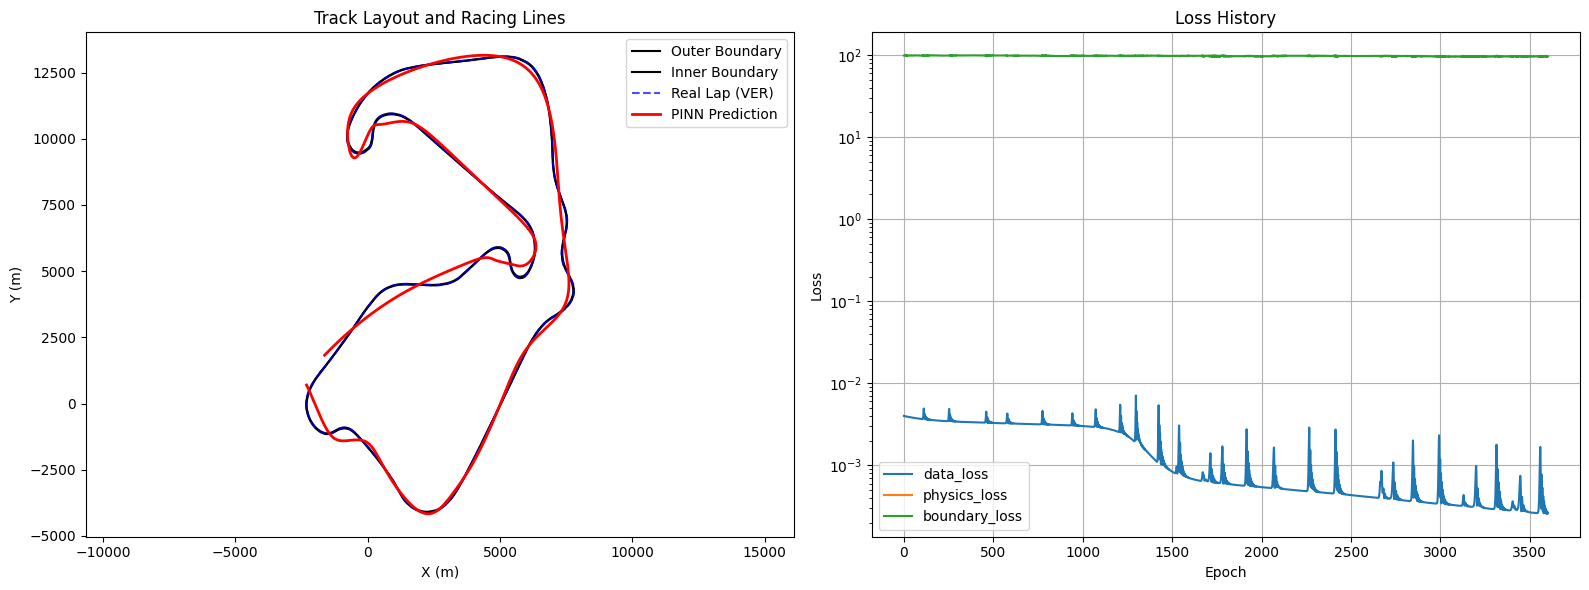

Epoch 3800/4000, Total Loss: 9.5902 | Data: 0.0002, Physics: 0.0000, Boundary: 95.9000


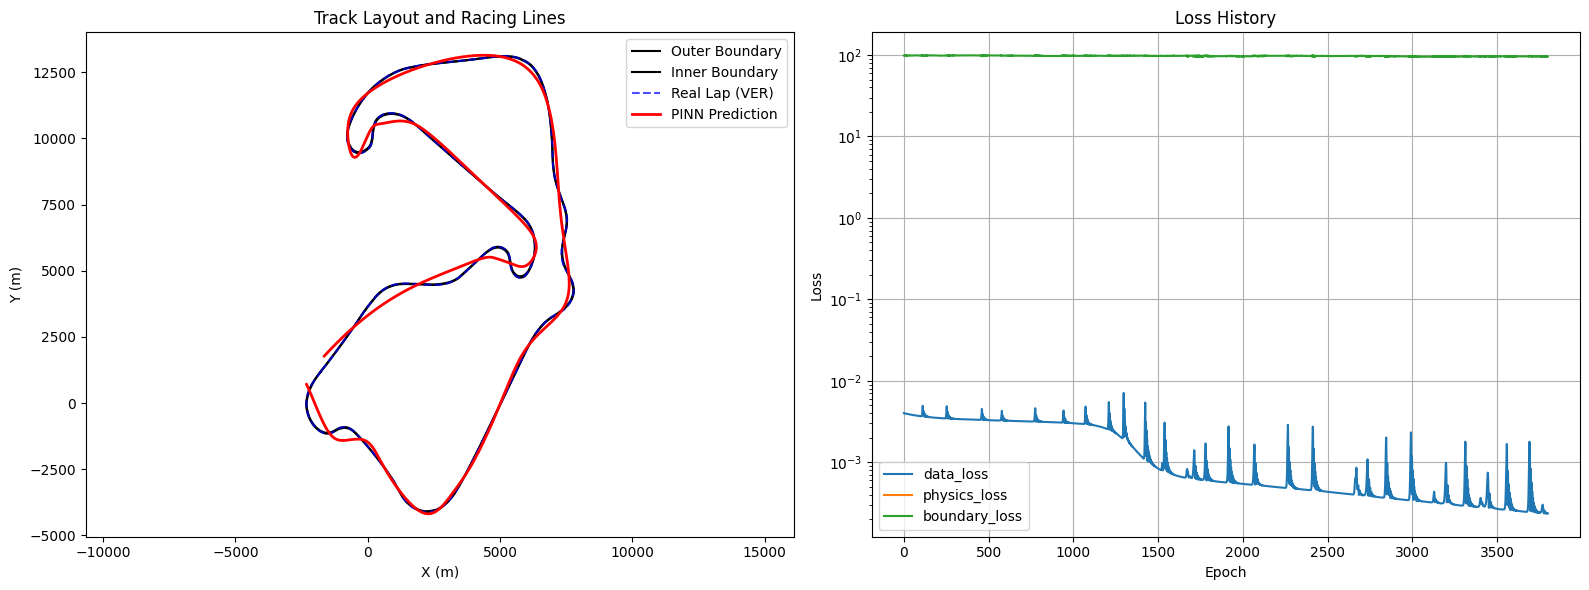

In [16]:
# --- REVISED Cell 3: Normalization, Instantiation, and Training ---

# 1. Add a simple scaler class
class Normalizer:
    def __init__(self, data):
        # Data is a numpy array
        self.min = data.min(axis=0)
        self.max = data.max(axis=0)

    def transform(self, data):
        # Get the number of columns from the data being transformed
        num_cols = data.shape[1]
        # Slice self.min and self.max to match
        min_vals = self.min[:num_cols]
        max_vals = self.max[:num_cols]
        # Scale data to the range [0, 1]
        return (data - min_vals) / (max_vals - min_vals + 1e-8)

    def inverse_transform(self, data):
        # Get the number of columns from the data being transformed
        num_cols = data.shape[1]
        # Slice self.min and self.max to match
        min_vals = self.min[:num_cols]
        max_vals = self.max[:num_cols]
        # Scale data back to original range
        return data * (max_vals - min_vals + 1e-8) + min_vals

# 2. Update the data loading function to use the normalizer
def load_and_normalize_training_data(path_to_data='data_cache/silverstone_2023_training.pkl'):
    with open(path_to_data, 'rb') as f:
        data = pickle.load(f)
        
    # We will still use the fastest lap as our ground truth
    x_true = data['positions'][0, :, 0]
    y_true = data['positions'][0, :, 1]
    speed_true = data['speeds'][0, :] / 3.6 # Convert to m/s

    # Combine into a single array before normalization
    ground_truth_unnormalized = np.vstack((x_true, y_true, speed_true)).T
    
    # Create and apply the normalizer
    scaler = Normalizer(ground_truth_unnormalized)
    ground_truth_normalized = scaler.transform(ground_truth_unnormalized)
    
    # Create tensors
    num_points = len(x_true)
    s_tensor = torch.linspace(0, 1, num_points, dtype=torch.float32).view(-1, 1)
    ground_truth_tensor = torch.tensor(ground_truth_normalized, dtype=torch.float32)
    
    print("✓ Data loaded and NORMALIZED.")
    return s_tensor, ground_truth_tensor, scaler

# --- Main Execution ---
s_tensor, ground_truth, scaler = load_and_normalize_training_data()
pinn_model = RacingPINN()

trainer = RacingPINNTrainer(pinn_model, s_tensor, ground_truth, scaler)

# --- Adjusted Weights for Balanced Training ---
# We give physics a larger weight and boundary a smaller one to encourage exploration.
trainer.train(epochs=4000, pretrain_epochs=1000, physics_weight=0.5, boundary_weight=0.1)